In [1]:
import tensorflow as tf
tf.__version__

import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random

import IPython.display as ipd
from scipy.io import wavfile
from scipy import signal
import os
import pathlib
import glob

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
from keras.models import Model, load_model, Sequential

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax, LeakyReLU
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, LSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers 

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

Using TensorFlow backend.


In [3]:
ROOT_PATH = 'speech/train'
AUDIO_PATH = 'speech/train/audio/'
NEW_PATH = 'speech/train/new/'
BACKGROUND_PATH = 'speech/train/audio/_background_noise_'
NOISE = 'speech/new_noise/'

In [4]:
def file_path(AUDIO_PATH):
    wav_list = []
    for root, dir_, files in os.walk(AUDIO_PATH):
        a = [str(root) + '/' + str(i) for i in files if i.endswith('.wav')]
        wav_list.extend(a)
    return wav_list

bg_list = file_path(BACKGROUND_PATH)
bg_list

['speech/train/audio/_background_noise_/doing_the_dishes.wav',
 'speech/train/audio/_background_noise_/exercise_bike.wav']

In [5]:
labels = ['off', 'down', 'on', 'up', 'right', 'left']

In [6]:
file_list = []
for root, dir_, files in os.walk(AUDIO_PATH):
    if os.path.basename(root) in labels:
        a = [str(root) + '/' + str(i) for i in files]
        file_list.append(a)
    else:
        pass

for ele in file_list:
    print(len(ele))

2375
2357
2367
2353
2359
2367


In [7]:
def load_file(path):
    sample, sample_rate = librosa.load(path, sr=16000)
    return sample

def mkdir(path):
    if os.path.exists(path) == True:
        pass
    else:
        os.mkdir(path)

In [8]:
for i in range(len(labels)):
    path = NOISE + labels[i]
    mkdir(path)

In [9]:
def add_noise(path1, path2):
    for i in range(len(path2)):
        path = 'speech/new_noise/' + path2[i].split('/')[-2] + '/'
        bg = random.choice(path1)
        bg, _ = librosa.load(bg, sr=16000, duration=1)
        target,_ = librosa.load(path2[i], sr=16000)
        try:
            join = np.array(target) + np.array(bg)*0.01
            librosa.output.write_wav(path + str(i) + '.wav', join, sr=16000)
        except:
            pass

In [10]:
# for i in range(len(labels)):
#     path2 = file_list[i]
#     j = load_file(path2[0])
#     print(len(j))
#     add_noise(bg_list, path2)

In [11]:
# Get full path from the new noise added file
new_labels = []
new_list = []
for root, dir_, files in os.walk(NOISE):
    if os.path.basename(root) in labels:
        new_labels.append(os.path.basename(root))
        a = [str(root) + '/' + str(i) for i in files]
        new_list.append(a)
    else:
        pass

for ele in new_list:
    print(len(ele))

2062
2143
2155
2165
2152
2105


In [12]:
# Add my voice data to the list
for root, dir_, files in os.walk(NEW_PATH):
    if os.path.basename(root) in new_labels:
        a = [str(root) + '/' + str(i) for i in files]
        new_list[new_labels.index(os.path.basename(root))].extend(a)
    else:
        pass

# We can see that the len of the sublist has changed   
for ele in new_list:
    print(len(ele))

2083
2163
2155
2165
2173
2127


In [13]:
new_labels
len(new_list)

6

In [14]:
# Test the sound of new file
idx = random.randint(0, 5)
print(new_labels[idx], idx)
sample = random.choice(new_list[idx])
audio  = load_file(sample)
ipd.Audio(audio, rate=16000)

off 1


In [15]:
my_voice = new_list[0][-1]
audio  = load_file(my_voice)
ipd.Audio(audio, rate=16000)

((128, 32), array([[-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        ...,
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.]], dtype=float32))

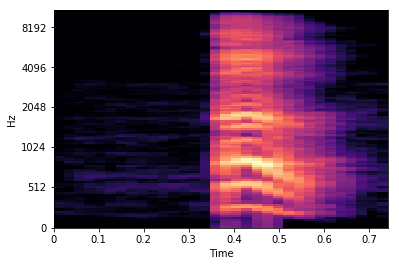

In [16]:
def plot_spec(file):
    sample, rate = librosa.load(file, sr=16000)
    train_spec = librosa.feature.melspectrogram(sample, sr=16000) 
    train_spec = librosa.power_to_db(train_spec, ref=np.max)
    librosa.display.specshow(train_spec, x_axis='time', y_axis='mel')

    return (train_spec.shape, train_spec)

plot_spec(new_list[0][0])

((128, 32), array([[-38.385136 , -38.955265 , -31.704786 , ..., -16.290924 ,
         -21.260635 , -37.658714 ],
        [-37.880943 , -42.953487 , -44.06394  , ..., -11.2057705,
         -24.88948  , -40.822132 ],
        [-28.799429 , -28.95278  , -30.640112 , ..., -12.544168 ,
         -28.220547 , -33.229496 ],
        ...,
        [-72.36668  , -73.703575 , -73.25348  , ..., -73.1594   ,
         -75.59643  , -77.19233  ],
        [-71.624756 , -76.757706 , -79.95301  , ..., -79.03991  ,
         -80.       , -80.       ],
        [-73.079895 , -79.00739  , -80.       , ..., -80.       ,
         -80.       , -80.       ]], dtype=float32))

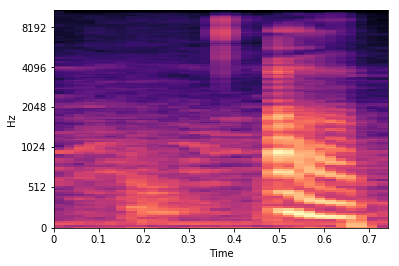

In [17]:
plot_spec(my_voice)

In [18]:
## Funtion to save spectrogram pic
def save_pic(sample, sr=16000):
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    spec_features = librosa.feature.melspectrogram(sample, sr=sr)
    spec_db = librosa.power_to_db(spec_features, ref=np.max)

    librosa.display.specshow(spec_db, x_axis='time', y_axis='mel')

    plt.savefig('spec.jpg', dpi=400, bbox_inches='tight', pad_inches=0)
    

## Prepare data for train and test

In [19]:
import itertools

y = []
new_merged = list(itertools.chain(*new_list))

for i in new_merged:
    label = i.split('/')[-2]
    y.append(label)

print(len(y))

12866


In [20]:
encode = LabelEncoder()
y = encode.fit_transform(y)
print(y)

[5 5 5 ... 3 3 3]


## CNN

In [21]:
X_cnn = []
from tqdm import tqdm
for i in tqdm(new_merged):
    wave = librosa.load(i, sr=16000)[0]
    wave = np.array(wave.reshape(16000,1))
    X_cnn.append(wave)
    
print(len(X_cnn))

100%|██████████| 12866/12866 [01:27<00:00, 146.97it/s]

12866


In [22]:
from sklearn.model_selection import train_test_split 
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(np.array(X_cnn), np.array(y), random_state=42, shuffle=True, test_size=0.2)

In [23]:
X_train_cnn.shape

(10292, 16000, 1)

In [24]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(16000,1))

#1st Conv1D layer
conv = Conv1D(8, 13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#2nd layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)


#3rd layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)


#4th layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)


#Flatten
conv = Flatten()(conv)

#Dense 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)


#Dense 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)


#Output
output = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs,output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15988, 8)          112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5329, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5329, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5319, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1773, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1773, 16)          0   

In [25]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='min')

In [26]:
BATCH = 64
history = model.fit(X_train_cnn, y_train_cnn ,epochs=30, callbacks=[es,mc], batch_size=BATCH, validation_split=0.2, shuffle=True)

Train on 8233 samples, validate on 2059 samples
Epoch 1/30
8233/8233 [==============================] - 6s 746us/step - loss: 1.6838 - accuracy: 0.2739 - val_loss: 1.4433 - val_accuracy: 0.4099
Epoch 2/30
1024/8233 [==>...........................] - ETA: 1s - loss: 1.4313 - accuracy: 0.4248

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8233/8233 [==============================] - 2s 215us/step - loss: 1.2812 - accuracy: 0.4826 - val_loss: 1.1230 - val_accuracy: 0.5809
Epoch 3/30
8233/8233 [==============================] - 2s 214us/step - loss: 1.0245 - accuracy: 0.6093 - val_loss: 0.9016 - val_accuracy: 0.6498
Epoch 4/30
8233/8233 [==============================] - 2s 213us/step - loss: 0.8696 - accuracy: 0.6714 - val_loss: 0.7816 - val_accuracy: 0.7115
Epoch 5/30
8233/8233 [==============================] - 2s 212us/step - loss: 0.7633 - accuracy: 0.7142 - val_loss: 0.6934 - val_accuracy: 0.7508
Epoch 6/30
8233/8233 [==============================] - 2s 213us/step - loss: 0.6889 - accuracy: 0.7459 - val_loss: 0.6738 - val_accuracy: 0.7620
Epoch 7/30
8233/8233 [==============================] - 2s 214us/step - loss: 0.6347 - accuracy: 0.7656 - val_loss: 0.6594 - val_accuracy: 0.7722
Epoch 8/30
8233/8233 [==============================] - 2s 214us/step - loss: 0.5691 - accuracy: 0.7921 - val_loss: 0.6146 - val_accura

In [27]:
model.save_weights('CNN.hdf5')
model.save('CNN.h5')

## LSTM-64-20features

In [28]:
X_20 = []
from tqdm import tqdm
for i in tqdm(new_merged):
        temp=librosa.feature.mfcc(librosa.load(i)[0])
        assert temp.shape == (20,44)
        X_20.append(temp)
print(len(X_20))

100%|██████████| 12866/12866 [05:30<00:00, 38.97it/s]

12866


In [29]:
from sklearn.model_selection import train_test_split 
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(np.array(X_20), np.array(y), random_state=42, shuffle=True, test_size=0.2)

In [34]:
lstm_64 = Sequential()
lstm_64.add(LSTM(64, input_shape=(20, 44)))
lstm_64.add(Dropout(0.2))
lstm_64.add(Dense(6))
lstm_64.add(Activation("softmax"))

lstm_64.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
                   metrics=['acc'])

In [35]:
lstm_64.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                27904     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
_________________________________________________________________
activation_2 (Activation)    (None, 6)                 0         
Total params: 28,294
Trainable params: 28,294
Non-trainable params: 0
_________________________________________________________________


In [40]:
lstm_64.fit(X_train_20, y_train_20, 
               validation_split=0.2,
               batch_size=64, 
               epochs=30, shuffle=True)

Train on 8233 samples, validate on 2059 samples
Epoch 1/30
8233/8233 [==============================] - 3s 320us/step - loss: 0.6052 - acc: 0.7769 - val_loss: 1.8364 - val_acc: 0.4143
Epoch 2/30
8233/8233 [==============================] - 3s 331us/step - loss: 0.6085 - acc: 0.7725 - val_loss: 1.8062 - val_acc: 0.4206
Epoch 3/30
8233/8233 [==============================] - 3s 319us/step - loss: 0.5827 - acc: 0.7868 - val_loss: 1.8771 - val_acc: 0.4225
Epoch 4/30
8233/8233 [==============================] - 3s 318us/step - loss: 0.5751 - acc: 0.7868 - val_loss: 1.8723 - val_acc: 0.4206
Epoch 5/30
8233/8233 [==============================] - 3s 322us/step - loss: 0.5609 - acc: 0.7958 - val_loss: 1.9002 - val_acc: 0.4094
Epoch 6/30
8233/8233 [==============================] - 3s 322us/step - loss: 0.5691 - acc: 0.7896 - val_loss: 1.8920 - val_acc: 0.4235
Epoch 7/30
8233/8233 [==============================] - 3s 325us/step - loss: 0.5401 - acc: 0.8026 - val_loss: 1.9591 - val_acc: 0.4250


## SHALLOW NEURON NETWORK

In [41]:
# Stop training well validation accuracy decreases
early_stop_callback = EarlyStopping(monitor='val_categorical_accuracy', 
                                    patience=5000, mode='max')

In [42]:
hidden_size = 64
batch_size = 32


In [43]:
shallow = Sequential()
shallow.add(Flatten(input_shape=(20, 44)))
# lstm64_model.add(Dropout(0.2))
shallow.add(Dense(1024))
shallow.add(LeakyReLU(alpha=0.2))
shallow.add(Dense(6))
shallow.add(Activation("softmax"))

shallow.compile(optimizer= optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True), loss="sparse_categorical_crossentropy",
                   metrics=['acc'])

In [44]:
shallow.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 880)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              902144    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 6150      
_________________________________________________________________
activation_3 (Activation)    (None, 6)                 0         
Total params: 908,294
Trainable params: 908,294
Non-trainable params: 0
_________________________________________________________________


In [46]:
shallow.fit(X_train_20, y_train_20, 
               validation_split=0.2,
               batch_size=batch_size, 
               callbacks=[early_stop_callback],
               epochs=30, shuffle=True)

Train on 8233 samples, validate on 2059 samples
Epoch 1/30
8233/8233 [==============================] - 1s 80us/step - loss: nan - acc: 0.1709 - val_loss: nan - val_acc: 0.1598
Epoch 2/30
8233/8233 [==============================] - 1s 76us/step - loss: nan - acc: 0.1709 - val_loss: nan - val_acc: 0.1598
Epoch 3/30
8233/8233 [==============================] - 1s 75us/step - loss: nan - acc: 0.1709 - val_loss: nan - val_acc: 0.1598
Epoch 4/30
8233/8233 [==============================] - 1s 77us/step - loss: nan - acc: 0.1709 - val_loss: nan - val_acc: 0.1598
Epoch 5/30
8233/8233 [==============================] - 1s 75us/step - loss: nan - acc: 0.1709 - val_loss: nan - val_acc: 0.1598
Epoch 6/30
8233/8233 [==============================] - 1s 77us/step - loss: nan - acc: 0.1709 - val_loss: nan - val_acc: 0.1598
Epoch 7/30
8233/8233 [==============================] - 1s 75us/step - loss: nan - acc: 0.1709 - val_loss: nan - val_acc: 0.1598
Epoch 8/30
8233/8233 [===========================

In [47]:
shallow.save('models/shallow.h5')

## LSTM-128-99features

In [48]:
X = []
from tqdm import tqdm
for i in tqdm(new_merged):
        temp=librosa.feature.mfcc(librosa.load(i)[0], n_mfcc=99)
        assert temp.shape == (99,44)
        X.append(temp)
print(len(X))

100%|██████████| 12866/12866 [05:29<00:00, 39.09it/s]

12866


In [49]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), random_state=42, shuffle=True, test_size=0.2)

In [50]:
# Stop training well validation accuracy decreases
early_stop_callback = EarlyStopping(monitor='val_categorical_accuracy', 
                                    patience=2, mode='max')

In [51]:
hidden_size = 128
batch_size = 32

In [53]:
lstm_model = Sequential()
lstm_model.add(LSTM(hidden_size, input_shape=(99, 44)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(6))
lstm_model.add(Activation("softmax"))

lstm_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
                   metrics=['acc'])

In [54]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               88576     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
_________________________________________________________________
activation_4 (Activation)    (None, 6)                 0         
Total params: 89,350
Trainable params: 89,350
Non-trainable params: 0
_________________________________________________________________


In [55]:
lstm_model.fit(X_train, y_train, 
               validation_split=0.2,
               batch_size=batch_size, 
               callbacks=[early_stop_callback],
               epochs=10, shuffle=True)

Train on 8233 samples, validate on 2059 samples
Epoch 1/10
8233/8233 [==============================] - 25s 3ms/step - loss: 1.7835 - acc: 0.2048 - val_loss: 1.6954 - val_acc: 0.2661
Epoch 2/10
  64/8233 [..............................] - ETA: 22s - loss: 1.5246 - acc: 0.4375

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: val_acc,loss,acc,val_loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


8233/8233 [==============================] - 25s 3ms/step - loss: 1.5776 - acc: 0.3277 - val_loss: 1.6196 - val_acc: 0.3001
Epoch 3/10
8233/8233 [==============================] - 25s 3ms/step - loss: 1.4582 - acc: 0.3884 - val_loss: 1.5784 - val_acc: 0.3079
Epoch 4/10
8233/8233 [==============================] - 25s 3ms/step - loss: 1.3507 - acc: 0.4422 - val_loss: 1.5836 - val_acc: 0.3084
Epoch 5/10
8233/8233 [==============================] - 25s 3ms/step - loss: 1.2413 - acc: 0.4953 - val_loss: 1.6438 - val_acc: 0.3099
Epoch 6/10
8233/8233 [==============================] - 25s 3ms/step - loss: 1.1369 - acc: 0.5411 - val_loss: 1.7385 - val_acc: 0.2982
Epoch 7/10
8233/8233 [==============================] - 25s 3ms/step - loss: 1.0169 - acc: 0.5971 - val_loss: 1.7487 - val_acc: 0.2953
Epoch 8/10
8233/8233 [==============================] - 24s 3ms/step - loss: 0.9095 - acc: 0.6472 - val_loss: 1.7941 - val_acc: 0.3273
Epoch 9/10
8233/8233 [==============================] - 24s 3ms/st

In [56]:
lstm_model.save('models/LSTM128.h5')

## EVALUATE ACCURACY

In [57]:
def get_classification_metrics(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=1)
    print(confusion_matrix(y_true, y_pred))
    print('\n')
    print(classification_report(y_true, y_pred))
    return confusion_matrix(y_true, y_pred), classification_report(y_true, y_pred)

## CNN

In [58]:
y_pred_cnn = model.predict(X_test_cnn)
np.argmax(y_pred_cnn, axis=1)

array([2, 5, 5, ..., 2, 5, 0])

[[384  11   2  18  14   8]
 [  9 382   8   2  16  11]
 [  1   5 377  21   5  59]
 [ 10   0  15 345   6  15]
 [  9  31   3   8 368  13]
 [  3   9  53  10   7 336]]


             precision    recall  f1-score   support

          0       0.92      0.88      0.90       437
          1       0.87      0.89      0.88       428
          2       0.82      0.81      0.81       468
          3       0.85      0.88      0.87       391
          4       0.88      0.85      0.87       432
          5       0.76      0.80      0.78       418

avg / total       0.85      0.85      0.85      2574

['up', 'off', 'right', 'left', 'down', 'on']


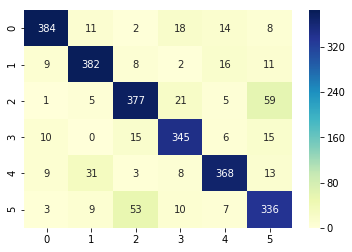

In [59]:
matrix_cnn, report_cnn = get_classification_metrics(y_test_cnn, y_pred_cnn)
sns.heatmap(matrix_cnn, annot=True, fmt='d',  cmap="YlGnBu")
print(new_labels)

## Shallow neuron network

In [62]:
y_pred_cnn = shallow.predict(X_test_20)
np.argmax(y_pred_cnn, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

[[437   0   0   0   0   0]
 [428   0   0   0   0   0]
 [468   0   0   0   0   0]
 [391   0   0   0   0   0]
 [432   0   0   0   0   0]
 [418   0   0   0   0   0]]


             precision    recall  f1-score   support

          0       0.17      1.00      0.29       437
          1       0.00      0.00      0.00       428
          2       0.00      0.00      0.00       468
          3       0.00      0.00      0.00       391
          4       0.00      0.00      0.00       432
          5       0.00      0.00      0.00       418

avg / total       0.03      0.17      0.05      2574

['up', 'off', 'right', 'left', 'down', 'on']


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


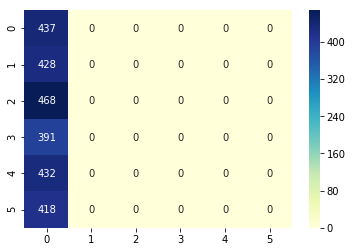

In [63]:
matrix_cnn, report_cnn = get_classification_metrics(y_test_20, y_pred_cnn)
sns.heatmap(matrix_cnn, annot=True, fmt='d',  cmap="YlGnBu")
print(new_labels)

## LSTM-64-20feature

In [67]:
y_pred_20 = lstm_64.predict(X_test_20)
np.argmax(y_pred_20, axis=1)

array([2, 1, 0, ..., 4, 2, 3])

[[166  38  49  93  48  43]
 [ 38 159  54  19 105  53]
 [ 31  55 214  76  15  77]
 [ 83  19  82 154  16  37]
 [ 59  75  14  26 205  53]
 [ 34  53 100  43  47 141]]


             precision    recall  f1-score   support

          0       0.40      0.38      0.39       437
          1       0.40      0.37      0.38       428
          2       0.42      0.46      0.44       468
          3       0.37      0.39      0.38       391
          4       0.47      0.47      0.47       432
          5       0.35      0.34      0.34       418

avg / total       0.40      0.40      0.40      2574

['up', 'off', 'right', 'left', 'down', 'on']


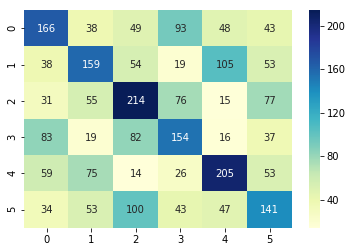

In [69]:
matrix_cnn, report_cnn = get_classification_metrics(y_test_20, y_pred_20)
sns.heatmap(matrix_cnn, annot=True, fmt='d',  cmap="YlGnBu")
print(new_labels)

## LSTM-128-99feature

In [71]:
y_pred_99 = lstm_model.predict(X_test)
np.argmax(y_pred_99, axis=1)

array([4, 5, 5, ..., 5, 2, 2])

[[174  25  26 146  47  19]
 [ 16  90 100  38  80 104]
 [ 22  83 115  53  77 118]
 [137  31  34 125  42  22]
 [ 46  80  80  85  75  66]
 [  8  63  78  21  23 225]]


             precision    recall  f1-score   support

          0       0.43      0.40      0.41       437
          1       0.24      0.21      0.23       428
          2       0.27      0.25      0.26       468
          3       0.27      0.32      0.29       391
          4       0.22      0.17      0.19       432
          5       0.41      0.54      0.46       418

avg / total       0.30      0.31      0.31      2574



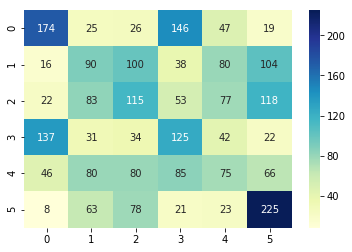

In [73]:
matrix, report = get_classification_metrics(y_test, y_pred_99)
sns.heatmap(matrix, annot=True, fmt='d',  cmap="YlGnBu")